In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import unittest
from textwrap import dedent
import sys

import networkx as nx
import matplotlib.pyplot as plt

from klara.core.cfg import Cfg
from klara.core.tree_rewriter import AstBuilder
from klara.core.use_def_chain import DefUseLinker, link_stmts_to_def

from cascade.frontend.dataflow_analysis.group_dataflow_nodes import GroupDataflowNodes
from cascade.frontend.dataflow_analysis.edge_placement import EdgePlacement
from cascade.frontend.dataflow_analysis.class_list import ClassList
from cascade.frontend.dataflow_analysis.class_list_builder import ClassListBuilder
from cascade.frontend.dataflow_analysis.class_wrapper import ClassWrapper
from cascade.frontend.util import setup_cfg, plot_graph_with_color, plot_dataflow_graph
from cascade.frontend.intermediate_representation import StatementDataflowGraph, DataflowGraph

# Dataflow Example

In [6]:
example = dedent("""\
                    class User: 
                        def checkout(self, discount: Discount, item_1: Item, item_2: Item):
                            bill = self.get_bill()
                            discount = discount.get_discount()
                            price_1 = item_1.price(discount)
                            price_2 = item_2.price(discount)
                            bill = bill + price_1
                            bill = bill + price_2
                            return bill
                    
                    class Item:
                        pass
                 
                    class Discount:
                        pass
                    """)

In [7]:
example = dedent(example)
cfg = setup_cfg(example)
class_list: ClassList = ClassListBuilder.build(cfg)
entity_1: ClassWrapper = class_list.get_class_by_name('User')
dataflow_graph: StatementDataflowGraph = entity_1.methods['checkout']
G = dataflow_graph.graph
grouper: GroupDataflowNodes = GroupDataflowNodes(G)
groups =  grouper.group_nodes()
f1 = plt.figure(1)
edge_placement: EdgePlacement = EdgePlacement(G, groups)
H = edge_placement.create_dataflow_graph()

<Figure size 640x480 with 0 Axes>

## Statement level data-dependency graph

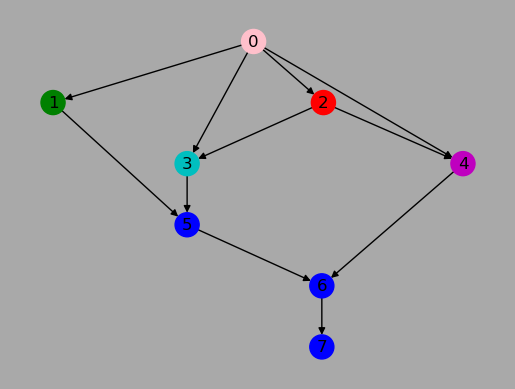

In [8]:
plot_graph_with_color(G)

## Dataflow graph
- Group statements together and remove redundant edges

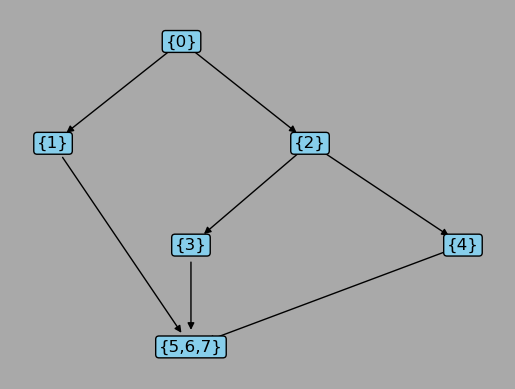

In [9]:
plot_dataflow_graph(H)

## Statement groups

In [10]:
print('Block groups of H')
for block in H.nodes:
    print(f'\n block num {block.block_num}')
    for statement in block.statement_list:
        print(statement.block)

Block groups of H

 block num 0
Function checkout in scope Class "User" in scope Module

 block num 1
Assign: (bill_0,) = Call: self_0.get_bill(())

 block num 2
Assign: (discount_1,) = Call: discount_0.get_discount(())

 block num 3
Assign: (price_1_0,) = Call: item_1_0.price((discount_1,))

 block num 4
Assign: (price_2_0,) = Call: item_2_0.price((discount_1,))

 block num 5
Assign: (bill_1,) = BinOp: bill_0 + price_1_0
Assign: (bill_2,) = BinOp: bill_1 + price_2_0


## Create split functions from statement groups

### Reveal color

In [11]:
for block in H.nodes:
    block.reveal_color()
    print(f'block: {block.block_num} has color: {block.color}')

block: 0 has color: -1
block: 1 has color: 1
block: 2 has color: 2
block: 3 has color: 3
block: 4 has color: 4
block: 5 has color: 0


All nodes are colored, therefore we must resolve which entities represent which colors.

In [12]:
block_level_dataflow_graph = DataflowGraph(H, dataflow_graph.color_type_map, dataflow_graph.method_name)
print(block_level_dataflow_graph.color_type_map)

{2: 'Discount', 3: 'Item', 4: 'Item', 1: 'User'}


### In variables per block.

In [36]:
from textwrap import indent
from cascade.frontend.generator.generate_split_functions import GenerateSplittFunctions
from cascade.frontend.intermediate_representation import Block

compiled_functions = GenerateSplittFunctions.generate_split_function_string(block_level_dataflow_graph)

In [ ]:


for node in block_level_dataflow_graph.get_nodes():
    node: Block
    print(f'block {node.block_num} in vars: {node.in_vars}')



block 0 in vars: {'discount_0', 'item_2_0', 'item_1_0', 'self_0'}
block 1 in vars: {'self_0'}
block 2 in vars: {'discount_0'}
block 3 in vars: {'discount_1', 'item_1_0'}
block 4 in vars: {'item_2_0', 'discount_1'}
block 5 in vars: {'price_1_0', 'bill_0', 'price_2_0'}


In [37]:
print(compiled_functions)

def stateless_entity_compiled_method_0(variable_map: dict[str, Any], *, state: StatelessEntity, key_stack: list[str]): 
	discount_0 = variable_map['discount_0']
	item_2_0 = variable_map['item_2_0']
	item_1_0 = variable_map['item_1_0']
	self_0 = variable_map['self_0']
	key_stack.append([self.key, discount.key]))

def stateless_entity_compiled_method_5(variable_map: dict[str, Any], *, state: StatelessEntity, key_stack: list[str]): 
	price_1_0 = variable_map['price_1_0']
	bill_0 = variable_map['bill_0']
	price_2_0 = variable_map['price_2_0']
	Assign: (bill_1,) = BinOp: bill_0 + price_1_0
	Assign: (bill_2,) = BinOp: bill_1 + price_2_0

def user_compiled_method_1(variable_map: dict[str, Any], *, state: User, key_stack: list[str]): 
	self_0 = variable_map['self_0']
	Assign: (bill_0,) = Call: self_0.get_bill(())
	key_stack.append(stateless_entity.key))

def discount_compiled_method_2(variable_map: dict[str, Any], *, state: Discount, key_stack: list[str]): 
	discount_0 = variable_map['discount

## Intermediate representation:
- A graph (nx.DiGraph) consisting of blocks
- Each block has an entity type
- and a statment list.
- The edges between the blocks encode the data flowing between the blocks.


In [34]:
from dataclasses import dataclass


@dataclass
class Block:
    statement_list: list["Statement"]
    block_num: int
    entity_type: EntityType
    input_edges: list[Edge]
    output_edges: list[Edge]

    def __hash__(self):
        return hash(self.block_num)


NameError: name 'EntityType' is not defined

## Edge and Entity

In [ ]:
class Entity:
    entity_type: EntityType
    key: Key

class Edge:
    entities: map[str, Entity]
    other_variables: map[str, ]
    variables = entities + other_variables
    from_node: Block
    to_node: Block

## Next steps
- Control dependencies (for loop / if statment)
- Compute data flowing over edges
- More elaborate examples (Deathstar Bench)